# 卷积神经网络（LeNet）

LeNet（LeNet-5）由两个部分组成： 卷积编码器和全连接层密集块

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

class Reshape(torch.nn.Module):
    def forward(self, X):
        return X.view(-1, 1, 28, 28)

net = torch.nn.Sequential(Reshape(), nn.Conv2d(1, 6, kernel_size=5,
                                              padding=2), nn.Sigmoid(),
                         nn.AvgPool2d(kernel_size=2, stride=2), 
                         nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
                         nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
                         nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
                         nn.Linear(120, 84), nn.Sigmoid(), nn.Linear(84, 10))

检查模型

In [3]:
import os
import torch

# 设置可见GPU（可选）
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 使用GPU 0

# 检查CUDA状态
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))
print("CUDA Available:", torch.cuda.is_available())
print("GPU数量:", torch.cuda.device_count())

# 显存分配测试
if torch.cuda.is_available():
    device = torch.device("cuda")
    x = torch.randn(1000, 1000).to(device)
    y = torch.randn(1000, 1000).to(device)
    z = x @ y
    print("显存占用:", torch.cuda.memory_allocated() / 1024**2, "MB")
else:
    print("CUDA不可用，请检查驱动或PyTorch安装！")


CUDA_VISIBLE_DEVICES: 0
CUDA Available: True
GPU数量: 1
显存占用: 11.44482421875 MB


In [4]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t', X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [5]:
torch.cuda.empty_cache()

LeNet在Fashion-MNIST数据集上的表现

In [6]:
batch_size=256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

对 evaluate_accuracy函数进行轻微的修改

In [7]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X),y), y.numel())
    return metric[0] / metric[1] 

为了使用 GPU，我们还需要一点小改动

In [8]:
def train_ch6(net, train_iter,test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)。"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) 
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_epochs // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

训练和评估LeNet-5模型

In [9]:
net = net.cuda()  # 确保模型在GPU
# train_iter = train_iter.cuda()    # 确保数据在GPU

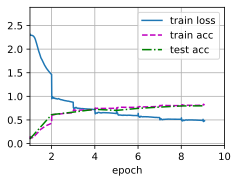

In [ ]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结

* 卷积神经网络（CNN）是一类使用卷积层的网络。
* 在卷积神经网络中，我们组合使用卷积层、非线性激活函数和汇聚层。
* 为了构造高性能的卷积神经网络，我们通常对卷积层进行排列，逐渐降低其表示的空间分辨率，同时增加通道数。
* 在传统的卷积神经网络中，卷积块编码得到的表征在输出之前需由一个或多个全连接层进行处理。
* LeNet是最早发布的卷积神经网络之一。